# Natural Gas Price Forecasting & Contract Valuation
Objective: Extrapolate natural gas prices for 1 year using seasonal trend analysis and calculate the value of a storage contract.

Methods: Linear Regression, Time-Series Decomposition.

In [ ]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Nat_Gas.csv")
df

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


In [3]:
df.shape

(48, 2)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

class NaturalGasPricer:
    def __init__(self, data_file):
        # Load the data
        self.df = pd.read_csv(data_file)
        
        
        self.df['Dates'] = pd.to_datetime(self.df['Dates'], format='%m/%d/%y') 
        
        self.df = self.df.sort_values('Dates').reset_index(drop=True)
        
        self.model_trend = None
        self.seasonal_adjustments = {}
        self._fit_model()

    def _fit_model(self):
        # 1. Convert dates to ordinal numbers
        self.df['DateOrdinal'] = self.df['Dates'].map(datetime.toordinal)
        
        # 2. Fit Linear Regression
        X = self.df[['DateOrdinal']]
        y = self.df['Prices']
        self.model_trend = LinearRegression()
        self.model_trend.fit(X, y)
        
        # 3. Calculate Seasonality
        self.df['TrendPrice'] = self.model_trend.predict(X)
        self.df['Deviation'] = self.df['Prices'] - self.df['TrendPrice']
        self.df['Month'] = self.df['Dates'].dt.month
        self.seasonal_adjustments = self.df.groupby('Month')['Deviation'].mean().to_dict()

    def estimate_price(self, date_str):
        target_date = pd.to_datetime(date_str)
        target_ordinal = target_date.toordinal()
        
        min_date = self.df['Dates'].min()
        max_date = self.df['Dates'].max()

        # CASE 1: PAST (Interpolation)
        if min_date <= target_date <= max_date:
            xp = self.df['DateOrdinal'].values
            fp = self.df['Prices'].values
            estimated_price = np.interp(target_ordinal, xp, fp)
            return round(estimated_price, 2)

        # CASE 2: FUTURE (Extrapolation)
        else:
            # Create a DataFrame with the feature name to silence the sklearn warning
            input_df = pd.DataFrame({'DateOrdinal': [target_ordinal]})
            trend_pred = self.model_trend.predict(input_df)[0]
            
            # Add seasonal adjustment
            month_idx = target_date.month
            seasonal_adj = self.seasonal_adjustments.get(month_idx, 0)
            
            return round(trend_pred + seasonal_adj, 2)

    def visualize(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.df['Dates'], self.df['Prices'], label='Actual History', marker='.')
        plt.plot(self.df['Dates'], self.df['TrendPrice'], label='Linear Trend', linestyle='--', alpha=0.5)
        
        last_date = self.df['Dates'].max()
        future_dates = [last_date + timedelta(days=x) for x in range(0, 365, 30)]
        future_prices = [self.estimate_price(d.strftime('%Y-%m-%d')) for d in future_dates]
        
        plt.plot(future_dates, future_prices, label='1-Year Forecast', color='red', linestyle='--')
        plt.title('Natural Gas Price: History vs. Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Initialize the object with the fix
pricer = NaturalGasPricer('Nat_Gas.csv')

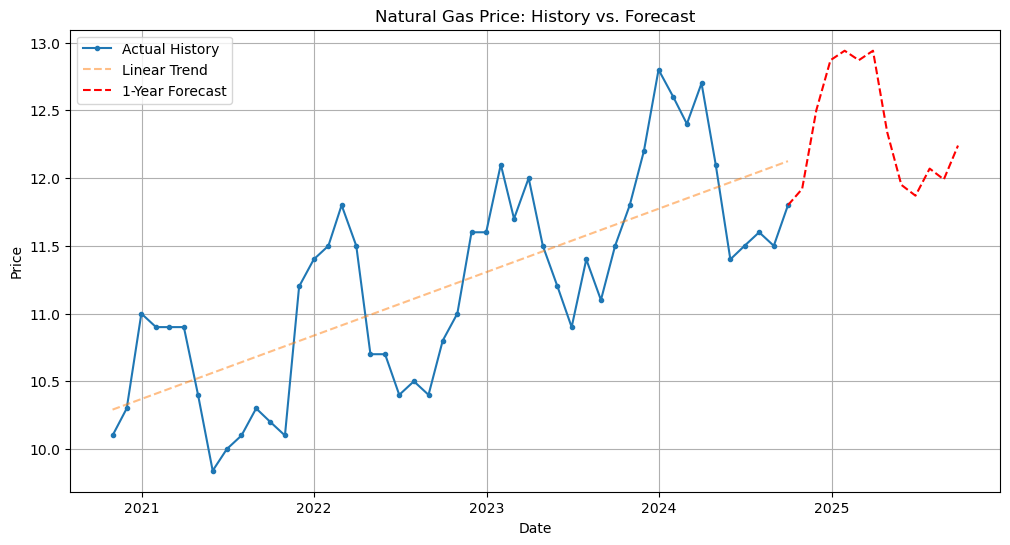

In [10]:
#  Create the plot
pricer.visualize()

In [ ]:
from datetime import date, timedelta
import math

def price_contract(in_dates, out_dates, price_model, 
                   inject_withdraw_fee_rate, 
                   max_volume, 
                   daily_storage_cost,
                   volume_per_action):
    """
    Calculates the value of a natural gas storage contract.
    
    Parameters:
    - in_dates: List of dates we buy/inject gas (e.g., ['2025-06-15'])
    - out_dates: List of dates we sell/withdraw gas (e.g., ['2025-12-15'])
    - price_model: The 'pricer' object you created in the previous cell
    - inject_withdraw_fee_rate: Cost to move gas per unit (e.g., $0.05)
    - max_volume: The maximum capacity of the storage
    - daily_storage_cost: Fixed daily rent for the facility
    - volume_per_action: How much gas is moved on each date
    
    Returns:
    - The profit/loss (Value) of the contract in dollars.
    """
    
    total_volume_in = 0
    total_cost_purchase = 0
    total_injection_fees = 0
    
    # --- 1. INJECTION (Buying Gas) ---
    # I tried to figure out the date range to calculate storage costs later
    start_date = None
    
    print("--- Injection (Buying) ---")
    for d_str in in_dates:
        # Ask the model from the previous cell what the price is
        p = price_model.estimate_price(d_str)
        
        # Calculate Cost
        cost = p * volume_per_action
        total_cost_purchase += cost
        total_injection_fees += (volume_per_action * inject_withdraw_fee_rate)
        total_volume_in += volume_per_action
        
        # Track the first date we put gas in
        current_date = pd.to_datetime(d_str)
        if start_date is None or current_date < start_date:
            start_date = current_date
            
        print(f"Date: {d_str} | Price: ${p:.2f} | Cost: ${cost:,.2f}")

    # --- 2. WITHDRAWAL (Selling Gas) ---
    total_volume_out = 0
    total_revenue = 0
    total_withdrawal_fees = 0
    end_date = None
    
    print("\n--- Withdrawal (Selling) ---")
    for d_str in out_dates:
        p = price_model.estimate_price(d_str)
        
        # Calculate Revenue
        revenue = p * volume_per_action
        total_revenue += revenue
        total_withdrawal_fees += (volume_per_action * inject_withdraw_fee_rate)
        total_volume_out += volume_per_action
        
        # Track the last date we take gas out
        current_date = pd.to_datetime(d_str)
        if end_date is None or current_date > end_date:
            end_date = current_date
            
        print(f"Date: {d_str} | Price: ${p:.2f} | Revenue: ${revenue:,.2f}")

    # --- 3. LOGIC CHECKS ---
    if total_volume_out > total_volume_in:
        print("\nERROR: You cannot sell more gas than you bought!")
        return 0
    if total_volume_in > max_volume:
        print("\nERROR: You exceeded the storage warehouse capacity!")
        return 0

    # --- 4. STORAGE COST CALCULATION ---
    # Calculate how many days the gas was sitting there
    storage_duration_days = (end_date - start_date).days
    total_storage_cost = storage_duration_days * daily_storage_cost

    # --- 5. FINAL PROFIT ---
    # Profit = Revenue - Purchase Cost - Moving Fees - Storage Rent
    contract_value = total_revenue - total_cost_purchase - total_injection_fees - total_withdrawal_fees - total_storage_cost
    
    print("\n" + "="*30)
    print(f"Total Revenue (Sales):      ${total_revenue:,.2f}")
    print(f"Total Purchase Cost:       -${total_cost_purchase:,.2f}")
    print(f"Injection/Withdraw Fees:   -${(total_injection_fees + total_withdrawal_fees):,.2f}")
    print(f"Storage Rent ({storage_duration_days} days):     -${total_storage_cost:,.2f}")
    print("="*30)
    print(f"NET CONTRACT VALUE:         ${contract_value:,.2f}")
    
    return contract_value

# --- TEST THE FUNCTION ---
# I used the 'pricer' object you created in the previous cell

# Scenario: Inject once in Summer, Withdraw once in Winter
injection_dates = ['2025-06-15'] 
withdrawal_dates = ['2025-12-15'] 

# Costs and Volumes
vol_per_action = 1000000  # 1 Million units
rate_fee = 0.01           # $0.01 per unit to inject/withdraw
storage_cost = 1000       # $1,000 per day rent
max_cap = 2000000         # Max 2 Million units

# Execute
value = price_contract(injection_dates, withdrawal_dates, pricer, rate_fee, max_cap, storage_cost, vol_per_action)

--- Injection (Buying) ---
Date: 2025-06-15 | Price: $11.85 | Cost: $11,850,000.00

--- Withdrawal (Selling) ---
Date: 2025-12-15 | Price: $13.32 | Revenue: $13,320,000.00

Total Revenue (Sales):      $13,320,000.00
Total Purchase Cost:       -$11,850,000.00
Injection/Withdraw Fees:   -$20,000.00
Storage Rent (183 days):     -$183,000.00
NET CONTRACT VALUE:         $1,267,000.00
